In [2]:
import numpy as np
import pandas as pd
import sys
import re
import time
import datetime
from time import time, gmtime, strftime
from datetime import datetime
import statistics
from tqdm import tqdm_notebook as tqdm
from __future__ import division
from collections import Counter
from gensim import models
import gensim, logging
from gensim.models import Word2Vec
import pickle
import seaborn as sns
from copy import deepcopy

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, LeavePOut
from sklearn.linear_model import LogisticRegression, ElasticNet, SGDClassifier, LogisticRegressionCV, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, cohen_kappa_score, roc_auc_score, roc_curve, auc, mutual_info_score, average_precision_score, precision_recall_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import word_tokenize as tokenizer
import jellyfish
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell # no need of print for several objects!!!
InteractiveShell.ast_node_interactivity = "all"

#pd.set_option('display.height', 1000)
#pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

%matplotlib inline

init_vec = True

2 possibilities:
- Load and merge samples and labels.
- Load pre-built dataset.

(go to either of them with Ctrl+F)

#### Load and merge samples and labels.

In [2]:
path = '/media/hdd/salaun/wikiedit/annotations/data_v1/'

file_list = ['00_09_42',
             '00_09_73',
             '10_19_42',
             '20_24_42',
             '25_29_42',
             '30_34_42',
             '35_39_42',
             '40_44_42_uniq_parag',
             '40_44_42',
             '40_44_73',
             '45_49_42',
             '45_49_73',
             '50_54_42',
             '50_54_73',
             '55_59_42',
             '55_59_73',
             '60_65_42',
             '66-69_72_42',
             '66-69_72_73'
              ]

df_sample = pd.concat([pd.read_csv(path + file + '_sample.tsv', sep="\t") for file in file_list], ignore_index=True)
df_post_annot = pd.concat([pd.read_csv(path + file + '_post_annot_S.csv', sep=';', header=None) for file in file_list], ignore_index=True)
df_post_annot.columns = ['index', 'sample_id', 'raw_annot']

print('Number of files:', len(file_list))
df_sample.shape
df_post_annot.shape

Number of files: 19


(1900, 35)

(1900, 3)

In [3]:
# get dummies
print('Length df_sample:', len(df_sample))
print('Length df_post_annot:', len(df_post_annot))

labels_lists = ['ortho_gram_typo','wiki_formatting', 'vandal', 'reordering', 
              'revert_vandal', 'revert_other', 'content_remove', 'content_add',
              'nbr_wr', 'nbr_rw', 'nbr_x', 
              'semant_simil', 'semant_diff', 
              'other']

gross_labels_list = ['semant', 'nbr', 'semant_or_nbr']

for label in labels_lists:
    df_post_annot[label] = df_post_annot.raw_annot.str.contains(label)


for label in gross_labels_list: #initialization
    df_post_annot[label] = False


for i in range(0, df_post_annot.shape[0]):
    
    if df_post_annot.semant_simil.iloc[i] or df_post_annot.semant_diff.iloc[i]:
        df_post_annot.loc[i,'semant'] = True

    if df_post_annot.nbr_wr.iloc[i] or df_post_annot.nbr_rw.iloc[i] or df_post_annot.nbr_x.iloc[i]:
        df_post_annot.loc[i,'nbr'] = True

    if df_post_annot.semant.iloc[i]==True or df_post_annot.nbr.iloc[i]==True:
        df_post_annot.loc[i,'semant_or_nbr'] = True

df_sample.shape
df_post_annot.shape

Length df_sample: 1900
Length df_post_annot: 1900


(1900, 35)

(1900, 20)

In [4]:
print("DISTRIBUTION OF LABELS OVER ALL ANNOTATIONS \n")

df_annot_distrib = pd.DataFrame(index=labels_lists, columns=['absolute number', 'share of all observations'])
df_annot_distrib_bis = pd.DataFrame(index=gross_labels_list, columns=['absolute number', 'share of all observations'])

for label in labels_lists:
    df_annot_distrib.loc[label,'absolute number'] = (df_post_annot[label]==1).sum()
    df_annot_distrib.loc[label,'share of all observations'] = 100*((df_post_annot[label]==1).sum())/len(df_post_annot)
df_annot_distrib 
    
for label in gross_labels_list:
    df_annot_distrib_bis.loc[label,'absolute number'] = (df_post_annot[label]==1).sum()
    df_annot_distrib_bis.loc[label,'share of all observations'] = 100*((df_post_annot[label]==1).sum())/len(df_post_annot)
df_annot_distrib_bis   

DISTRIBUTION OF LABELS OVER ALL ANNOTATIONS 



,absolute number,share of all observations
ortho_gram_typo,506,26.6316
wiki_formatting,696,36.6316
vandal,114,6
reordering,91,4.78947
revert_vandal,12,0.631579
revert_other,6,0.315789
content_remove,116,6.10526
content_add,477,25.1053
nbr_wr,39,2.05263
nbr_rw,7,0.368421


,absolute number,share of all observations
semant,355,18.6842
nbr,48,2.52632
semant_or_nbr,403,21.2105


In [7]:
df_XY = pd.concat([df_sample, df_post_annot.loc[:,'raw_annot':'semant_or_nbr']], axis=1)
df_XY.shape
df_XY.columns
df_XY = df_XY.fillna('')
df_XY.tail(2)

(1900, 53)

Index(['Unnamed: 0', 'comment', 'filt_bot', 'filt_coher', 'filt_confli',
       'filt_contradic', 'filt_erreur', 'filt_erron', 'filt_faux',
       'filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens',
       'filt_tromp', 'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format',
       'id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
       'modif', 'modif_add', 'modif_remove', 'parentid', 'registered',
       'sample_id', 'timestamp', 'title', 'user_id', 'username', 'raw_annot',
       'ortho_gram_typo', 'wiki_formatting', 'vandal', 'reordering',
       'revert_vandal', 'revert_other', 'content_remove', 'content_add',
       'nbr_wr', 'nbr_rw', 'nbr_x', 'semant_simil', 'semant_diff', 'other',
       'semant', 'nbr', 'semant_or_nbr'],
      dtype='object')

,Unnamed: 0,comment,filt_bot,filt_coher,filt_confli,filt_contradic,filt_erreur,filt_erron,filt_faux,filt_frappe,filt_gramma,filt_ortho,filt_revert,filt_sens,filt_tromp,filt_typo,filt_vandalisme,filt_vraise,format,id,id_file,id_modif,label_incoherence,minor,model,modif,modif_add,modif_remove,parentid,registered,sample_id,timestamp,title,user_id,username,raw_annot,ortho_gram_typo,wiki_formatting,vandal,reordering,revert_vandal,revert_other,content_remove,content_add,nbr_wr,nbr_rw,nbr_x,semant_simil,semant_diff,other,semant,nbr,semant_or_nbr
1898,98,,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,text/x-wiki,95886840,p5847438p6039053,1279779,False,False,wikitext,"- '''Michael Loewe''', de son vrai nom Mihai L...","'''Michael Loewe''', de son vrai nom Mihai Leu...","'''Michael Loewe''', de son vrai nom Mihai Leu...",95886829.0,True,p5847438p6039053_1279779,2013-08-17T21:34:39Z,Michael Loewe,31767,Skblzz1,ortho_gram_typo,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1899,99,/* Synopsis */,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,text/x-wiki,74105978,p5847438p6039053,1046153,False,False,wikitext,- Un homme et deux femmes se mettent à table. ...,Un homme et deux femmes se mettent à table. Au...,Un homme et deux femmes se mettent à table. Au...,74105972.0,True,p5847438p6039053_1046153,2012-01-09T02:18:33Z,Le Repas fantastique,418936,Celette,ortho_gram_typo,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


#### Load pre-built dataset.

In [8]:
#df_XY.to_csv(path + 'full_dataset_with_all_labels.tsv', sep='\t')

In [9]:
path = '/media/hdd/salaun/wikiedit/annotations/data_v1/'
df_XY = pd.read_csv(path + 'full_dataset_with_all_labels.tsv', sep='\t')
df_XY.columns
df_XY = df_XY.loc[:,'comment':'semant_or_nbr']
df_XY.shape

Index(['Unnamed: 0', 'Unnamed: 0.1', 'comment', 'filt_bot', 'filt_coher',
       'filt_confli', 'filt_contradic', 'filt_erreur', 'filt_erron',
       'filt_faux', 'filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert',
       'filt_sens', 'filt_tromp', 'filt_typo', 'filt_vandalisme',
       'filt_vraise', 'format', 'id', 'id_file', 'id_modif',
       'label_incoherence', 'minor', 'model', 'modif', 'modif_add',
       'modif_remove', 'parentid', 'registered', 'sample_id', 'timestamp',
       'title', 'user_id', 'username', 'raw_annot', 'ortho_gram_typo',
       'wiki_formatting', 'vandal', 'reordering', 'revert_vandal',
       'revert_other', 'content_remove', 'content_add', 'nbr_wr', 'nbr_rw',
       'nbr_x', 'semant_simil', 'semant_diff', 'other', 'semant', 'nbr',
       'semant_or_nbr'],
      dtype='object')

(1900, 52)

#### Merge samples and labels.

Concentrate **"incoherent"** samples that are the strings in ***modif_remove*** in pairs labeled as ***semant_diff***

In [10]:
df_incoher = df_XY[['comment', 'filt_bot', 'filt_coher', 'filt_confli',
       'filt_contradic', 'filt_erreur', 'filt_erron', 'filt_faux',
       'filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens',
       'filt_tromp', 'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format',
       'id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
       'modif_remove',
       'parentid', 'registered',
       'sample_id', 'timestamp', 'title', 'user_id', 'username', 'raw_annot']][df_XY.semant_diff].copy()
df_incoher = df_incoher.reset_index()
df_incoher = df_incoher.rename(columns = {'modif_remove':'string'})
df_incoher = pd.concat([df_incoher, pd.DataFrame({'incoherence':1}, index=df_incoher.index)], axis=1)

concentrate **"incoherent"** samples that are the strings in ***modif_add*** for pairs labeled as ***semant_diff***

and that are the strings in ***modif_*** for pairs labeled as ***semant_simil***

In [11]:
df_coher1 = df_XY[['comment', 'filt_bot', 'filt_coher', 'filt_confli','filt_contradic', 'filt_erreur', 'filt_erron',
                             'filt_faux','filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens','filt_tromp', 
                             'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format','id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
                             'modif_add',
                             'parentid', 'registered','sample_id', 'timestamp', 
                             'title', 'user_id', 'username', 'raw_annot']][df_XY.semant_diff].copy()
df_coher1 = df_coher1.rename(columns = {'modif_add':'string'})

df_coher2 = df_XY[['comment', 'filt_bot', 'filt_coher', 'filt_confli','filt_contradic', 'filt_erreur', 'filt_erron', 
                             'filt_faux','filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens','filt_tromp', 
                             'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format','id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
                             'modif_remove',
                             'parentid', 'registered','sample_id', 'timestamp', 
                             'title', 'user_id', 'username', 'raw_annot']][df_XY.semant_simil].copy()
df_coher2 = df_coher2.rename(columns = {'modif_remove':'string'})

df_coher3 = df_XY[['comment', 'filt_bot', 'filt_coher', 'filt_confli','filt_contradic', 'filt_erreur', 'filt_erron', 
                             'filt_faux','filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens','filt_tromp', 
                             'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format','id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
                             'modif_add',
                             'parentid', 'registered','sample_id', 'timestamp', 
                             'title', 'user_id', 'username', 'raw_annot']][df_XY.semant_simil].copy()
df_coher3 = df_coher3.rename(columns = {'modif_add':'string'})

df_coher = pd.concat([df_coher1,
                      df_coher2,
                      df_coher3],
                     axis = 0)

df_coher = df_coher.reset_index()

df_coher = pd.concat([df_coher, pd.DataFrame({'incoherence': 0}, index=df_coher.index)], axis=1)
#df_coher.columns = ['index', 'string', 'incoherence']

df = pd.concat([df_incoher, df_coher], axis=0, ignore_index=True)

Check homogeneity of each label group

In [12]:
df_incoher.incoherence.value_counts() # check if y_test == incoherence
df_coher.incoherence.value_counts()

1    143
Name: incoherence, dtype: int64

0    567
Name: incoherence, dtype: int64

In [13]:
df.incoherence.value_counts()
df.incoherence.value_counts(normalize=True)

0    567
1    143
Name: incoherence, dtype: int64

0    0.798592
1    0.201408
Name: incoherence, dtype: float64

In [14]:
df.shape
df.columns
df.tail(2)

(710, 35)

Index(['index', 'comment', 'filt_bot', 'filt_coher', 'filt_confli',
       'filt_contradic', 'filt_erreur', 'filt_erron', 'filt_faux',
       'filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens',
       'filt_tromp', 'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format',
       'id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
       'string', 'parentid', 'registered', 'sample_id', 'timestamp', 'title',
       'user_id', 'username', 'raw_annot', 'incoherence'],
      dtype='object')

,index,comment,filt_bot,filt_coher,filt_confli,filt_contradic,filt_erreur,filt_erron,filt_faux,filt_frappe,filt_gramma,filt_ortho,filt_revert,filt_sens,filt_tromp,filt_typo,filt_vandalisme,filt_vraise,format,id,id_file,id_modif,label_incoherence,minor,model,string,parentid,registered,sample_id,timestamp,title,user_id,username,raw_annot,incoherence
708,1893,NaN,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,text/x-wiki,34365984,p5847438p6039053,972379,False,False,wikitext,'''Oujda''' ([[arabe]] : ''wajda'' وجدة) est l...,34365556.0,True,p5847438p6039053_972379,2008-10-15T12:30:00Z,Oujda,210682.0,Barçawi,"wiki_formatting, content_add, semant_simil",0
709,1894,NaN,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,text/x-wiki,79013537,p5847438p6039053,1357657,False,False,wikitext,L'écartement des rails est 1000 mm et la tensi...,79013385.0,True,p5847438p6039053_1357657,2012-05-23T22:40:54Z,Tramway de Gand,584142.0,JG-Brill,"ortho_gram_typo, semant_simil",0


#### Filter editor-oriented text

In [15]:
string_pattern = '([a-zA-Z0-9ÀàÂâÆæÇçÈèÉéÊêËëÎîÏïÔôŒœÙùÛûÜü€₣]+|ref>|/ref>|\n\t|\'|[«».,\/#\|!$%\^&\*;:<>\[\]{}=\-_`~()])'

def wiki_normalize(s):
    s = re.sub(r'\[\[(?:[^\]|]*\|)?([^\]|]*)\]\]', r'\1', s.strip().lower())

    for element in [',', "pdf", "refnec", "référence nécessaire", "référence souhaitée", "..."]:
        s = s.replace("{{"+element+"}}","")
    s = re.sub(r'\{\{(?:[^\}|]*\|)?([^\}|]*)\}\}', r'\1', s.strip().lower())
    # remove {{ }} and remove {{a| from 

    #s = re.sub("\[[^\|]+\]", ' ', s.strip().lower())
    for element in ['\n', "'''''", "''''", "'''", "''"]:
        s = s.replace(element, " ")

    
    s = re.sub('<ref[^<]+</ref>', ' ', s) # https://stackoverflow.com/questions/12225729/regex-to-remove-text-between-tags-in-notepad
    

    s = re.sub('\{\{[^\|]+\|', ' ', s) # in {{a|b}} remove {{a| that is left ({{ and | are already removed)

    s = re.sub('<[^>]*>', ' ', s)
    s = re.sub('\[http[^\s]+\s', ' ', s)
    
    for element in ['|','{{', '}}', 'formatnum:','[...]', '[',']']:
        s = s.replace(element, " ")
        
    return s

def text_input_builder_bow(path):
    
    content = []
    i=0
    for line in open(path, "r+").readlines():   
        if not line.startswith('<') and not line.isspace():
            i+=1
            line = line.lower()
            line = wiki_normalize(line)
            line = re.findall(string_pattern, line) # turns line to list where all tokens are split
            line = " ".join(line) # all tokens are gathered in one string again with whitespaces as separators
            content.append(line)
        #if i == 400000:
        #    break
    return content

In [16]:
df.columns

Index(['index', 'comment', 'filt_bot', 'filt_coher', 'filt_confli',
       'filt_contradic', 'filt_erreur', 'filt_erron', 'filt_faux',
       'filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens',
       'filt_tromp', 'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format',
       'id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
       'string', 'parentid', 'registered', 'sample_id', 'timestamp', 'title',
       'user_id', 'username', 'raw_annot', 'incoherence'],
      dtype='object')

#### Check string length character and token-wise

In [17]:
for i in range(0, len(df)):
    df.loc[i,'string'] = wiki_normalize(df.loc[i,'string'])
    df.loc[i,'len'] = len(df.loc[i,'string'])
    df.loc[i,'len_tok'] = len(re.findall(string_pattern, df.loc[i, 'string'].strip().lower()))
    
df[['len']].describe()
df[['len_tok']].describe()

,len
count,710.000000
mean,594.595775
std,636.089970
min,22.000000
25%,209.250000
50%,401.000000
75%,722.000000
max,4795.000000


,len_tok
count,710.000000
mean,120.284507
std,127.517683
min,6.000000
25%,43.000000
50%,82.000000
75%,148.750000
max,969.000000


#### Check homogeneity of length (character and token wise) between label groups

In [18]:
df[['len']][df.incoherence == 0].describe()
df[['len']][df.incoherence == 1].describe()

,len
count,567.000000
mean,616.550265
std,636.822160
min,25.000000
25%,213.500000
50%,407.000000
75%,764.500000
max,4795.000000


,len
count,143.000000
mean,507.545455
std,627.844858
min,22.000000
25%,179.500000
50%,366.000000
75%,584.500000
max,4665.000000


In [19]:
df[['len_tok']][df.incoherence == 0].describe()
df[['len_tok']][df.incoherence == 1].describe()

,len_tok
count,567.000000
mean,124.407407
std,127.636388
min,6.000000
25%,43.500000
50%,83.000000
75%,156.000000
max,969.000000


,len_tok
count,143.000000
mean,103.937063
std,126.164783
min,6.000000
25%,37.000000
50%,74.000000
75%,114.000000
max,942.000000


#### Character-length distribution

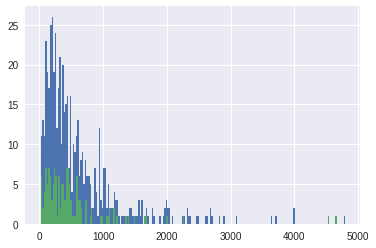

In [20]:
df[df.incoherence == 0].len.hist(bins=200)
df[df.incoherence == 1].len.hist(bins=200)

Token-length distribution

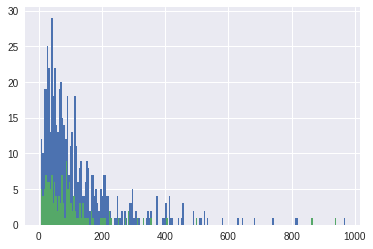

In [23]:
df[df.incoherence == 0].len_tok.hist(bins=200)
df[df.incoherence == 1].len_tok.hist(bins=200)

#### Language models (LM)

Run the cell below if the LM is not available (vector size = 100)

In [24]:
'''
#model100
#%%monitor_cell language_model_100

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
path = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'

content_input = text_input_builder_bow(path) # list where each sentence is a string

new_input = [string.split() for string in content_input] # list where each sentence is a list

#input_sentences must be list of lists of tokens
# https://rare-technologies.com/word2vec-tutorial/
model = Word2Vec(new_input, hs=1, negative=0)

#model.save('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')
'''

"\n#model100\n#%%monitor_cell language_model_100\n\nlogging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)\npath = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'\n\ncontent_input = text_input_builder_bow(path) # list where each sentence is a string\n\nnew_input = [string.split() for string in content_input] # list where each sentence is a list\n\n#input_sentences must be list of lists of tokens\n# https://rare-technologies.com/word2vec-tutorial/\nmodel = Word2Vec(new_input, hs=1, negative=0)\n\n#model.save('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')\n"

Load pre-defined model (vector size = 100)

In [25]:
# load the model again
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')

In [26]:
len(model.wv.vocab)

729651

Run the cell below if the LM is not available (vector size = 300)

In [27]:
'''
#model300
#%%monitor_cell language_model_300

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
path = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'

content_input = text_input_builder_bow(path) # list where each sentence is a string

new_input = [string.split() for string in content_input] # list where each sentence is a list

# input_sentences must be list of lists of tokens
# https://rare-technologies.com/word2vec-tutorial/
model = Word2Vec(new_input, size=300, hs=1, negative=0)

#model.save('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')
'''

"\n#model300\n#%%monitor_cell language_model_300\n\nlogging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)\npath = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'\n\ncontent_input = text_input_builder_bow(path) # list where each sentence is a string\n\nnew_input = [string.split() for string in content_input] # list where each sentence is a list\n\n# input_sentences must be list of lists of tokens\n# https://rare-technologies.com/word2vec-tutorial/\nmodel = Word2Vec(new_input, size=300, hs=1, negative=0)\n\n#model.save('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')\n"

Load pre-defined model (vector size = 300)

In [28]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')

#### Compute LM scores

In [29]:
df['score'] = 'NaN'
for row in range(0, df.shape[0]):
    s = df.loc[row,'string']
    df.loc[row, 'score'] = model.score([re.findall(string_pattern, s.strip().lower())])[0]
    df.loc[row, 'prob'] = np.exp(df.loc[row, 'score'])

In [30]:
df.describe()

,index,id,id_modif,parentid,user_id,incoherence,len,len_tok,prob
count,710.000000,7.100000e+02,7.100000e+02,7.100000e+02,4.200000e+02,710.000000,710.000000,710.000000,7.100000e+02
mean,979.270423,6.503335e+07,7.723672e+05,6.430306e+07,4.920554e+05,0.201408,594.595775,120.284507,4.868470e-17
std,579.034024,3.635788e+07,4.243845e+05,3.606699e+07,5.078479e+05,0.401335,636.089970,127.517683,1.102084e-15
min,0.000000,1.366927e+06,8.500000e+02,1.336409e+06,3.260000e+02,0.000000,22.000000,6.000000,0.000000e+00
25%,439.750000,3.586803e+07,4.282098e+05,3.564341e+07,1.204830e+05,0.000000,209.250000,43.000000,0.000000e+00
50%,1028.000000,6.014793e+07,7.735620e+05,5.883866e+07,3.264895e+05,0.000000,401.000000,82.000000,0.000000e+00
75%,1513.000000,9.334835e+07,1.131114e+06,9.145190e+07,7.015760e+05,0.000000,722.000000,148.750000,0.000000e+00
max,1894.000000,1.388645e+08,2.589875e+06,1.388645e+08,2.609867e+06,1.000000,4795.000000,969.000000,2.912112e-14


In [33]:
print('Mean scores for coherent and incoherent samples')
df.groupby('incoherence')["score"].apply(np.mean)
print('Median scores for coherent and incoherent samples')
df.groupby('incoherence')["score"].apply(np.median)
print('Standard deviation scores for coherent and incoherent samples')
df.groupby('incoherence')["score"].apply(np.std)

score_mean = df.groupby('incoherence')["score"].apply(np.mean)

# http://www.dummies.com/education/math/statistics/how-to-calculate-a-confidence-interval-for-a-population-mean-when-you-know-its-standard-deviation/
# https://www.google.fr/search?q=formula+confidence+interval&rlz=1C1CHBD_frFR751FR752&source=lnms&tbm=isch&sa=X&ved=0ahUKEwje3ungjarXAhWZHsAKHebRBCMQ_AUICigB&biw=1858&bih=989#imgrc=GmZzs6Zm4n8szM:
# formula CI : sample mean +/- 1.96 * pop sd / sqrt(sample size)
# should apply only if normal bell-shape curve !

print('Confidence interval coherent scores:')
print('{:.2f} +/- {:.2f}'.format(score_mean[0], 1.96 * df["score"].std() / (df.groupby('incoherence')['incoherence'].count()[0])**(0.5) ))
print('[ {:.2f} , {:.2f} ] \n'.format(score_mean[0] - 1.96 * df["score"].std() / (df.groupby('incoherence')['incoherence'].count()[0])**(0.5),  score_mean[0] + 1.96 * df["score"].std() / (df.groupby('incoherence')['incoherence'].count()[0])**(0.5)))

print('Confidence interval incoherent scores:')
print('{:.2f} +/- {:.2f}'.format(score_mean[1], 1.96 * df["score"].std() / (df.groupby('incoherence')['incoherence'].count()[1])**(0.5) ))
print('[ {:.2f} , {:.2f} ] \n'.format(score_mean[1] - 1.96 * df["score"].std() / (df.groupby('incoherence')['incoherence'].count()[1])**(0.5),  score_mean[1] + 1.96 * df["score"].std() / (df.groupby('incoherence')['incoherence'].count()[1])**(0.5)))


Mean scores for coherent and incoherent samples


incoherence
0   -772.678020
1   -642.116914
Name: score, dtype: float64

Median scores for coherent and incoherent samples


incoherence
0   -504.936768
1   -450.345825
Name: score, dtype: float64

Standard deviation scores for coherent and incoherent samples


incoherence
0    807.84501
1    786.17326
Name: score, dtype: float64

Confidence interval coherent scores:
-772.68 +/- 66.33
[ -839.01 , -706.35 ] 

Confidence interval incoherent scores:
-642.12 +/- 132.07
[ -774.19 , -510.04 ] 



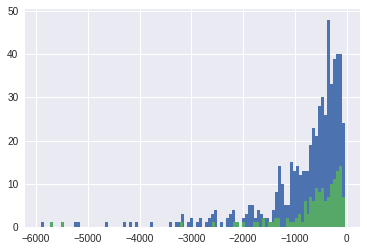

In [34]:
df[df["incoherence"]==0].score.hist(bins=100)
df[df["incoherence"]==1].score.hist(bins=100)

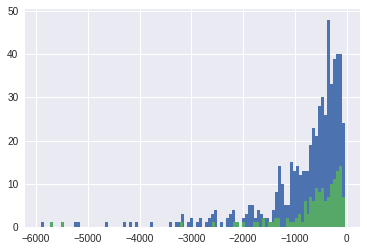

In [35]:
df[df["incoherence"]==0].score.hist(bins=100)
df[df["incoherence"]==1].score.hist(bins=100)

## Split train/test 

In [38]:
df_train = df.sample(frac=0.8)#,random_state=42)
df_test = df.drop(df_train.index).copy()
df_train = df_train.reset_index(drop=True).copy()
df_test = df_test.reset_index(drop=True).copy()
df_train = df_train.fillna('')
df_test = df_test.fillna('')

print('Distribution of labels in TRAIN set')
df_train.incoherence.value_counts()
df_train.incoherence.value_counts(normalize=True)
print('\n')
print('Distribution of labels in TEST set')
df_test.incoherence.value_counts()
df_test.incoherence.value_counts(normalize=True)

Distribution of labels in TRAIN set


0    453
1    115
Name: incoherence, dtype: int64

0    0.797535
1    0.202465
Name: incoherence, dtype: float64



Distribution of labels in TEST set


0    114
1     28
Name: incoherence, dtype: int64

0    0.802817
1    0.197183
Name: incoherence, dtype: float64

In [39]:
df_train.shape
df_test.shape

(568, 39)

(142, 39)

#### Functions

Choose either <code>cv_SKF</code>, <code>cv_RSKF</code> or <code>cv_LPO</code> for cross-validation setting.

In [40]:
cv_SKF = StratifiedKFold(n_splits=6, shuffle=True)
cv_RSKF = RepeatedStratifiedKFold(n_splits=6)
cv_LPO = LeavePOut(1)


def cross_val_series(X, y, clf, cv_input):
    
    metrics_list = ['precision', 'recall', 'f1', 'roc_auc'] #, 'neg_log_loss'
    df_scores = pd.DataFrame(index=metrics_list, columns=['score'])
    
    for metric in metrics_list:
        df_scores.loc[metric,'score'] = '{:.3f} (+/- {:.3f})'.format(cross_val_score(clf, X, y, cv=cv_input, scoring=metric).mean(), 1.96 * cross_val_score(clf, X, y, cv=cv_input, scoring=metric).std() / np.sqrt(len(cross_val_score(clf, X, y, cv=cv_input, scoring=metric))))
    return df_scores
    
    # roc_auc > needs to exceed 0.5
    # neg_log_loss > neg metric, needs to approach 0

Testing function.

In [41]:
def model_testing(X_train, y_train, X_test, y_test, model):
    
    metrics_list = ['precision', 'recall', 'f1', 'roc_auc']
    df_scores_test = pd.DataFrame(index=metrics_list, columns=['test_score'])
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    y_pred_proba = model.predict_proba(X_test)
    
    
    df_scores_test.loc['precision', 'test_score'] = '{:.3f}'.format(precision_score(y_test, y_pred))
    df_scores_test.loc['recall', 'test_score'] = '{:.3f}'.format(recall_score(y_test, y_pred))
    df_scores_test.loc['f1', 'test_score'] = '{:.3f}'.format(f1_score(y_test, y_pred))
    df_scores_test.loc['roc_auc', 'test_score'] = '{:.3f}'.format(roc_auc_score(y_test, y_pred_proba[:,1]))
    
    full_test_df = df_test.copy()
    full_test_df['y_test'] = pd.DataFrame(y_test)
    full_test_df['y_pred'] = pd.DataFrame(y_pred)
    full_test_df['y_pred_proba'] = pd.DataFrame(y_pred_proba[:,1])
    
    return df_scores_test, full_test_df, y_test, y_pred, y_pred_proba

Plot ROC curve.

In [42]:
def plot_roc_auc(y_test, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1], pos_label=1)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

## Method 1: BOW

Build new model (cell below) or load pre-existing model (next cell below)

In [43]:
%%time
#path = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'
#txt_input = text_input_builder_bow(path)
#vectorizer = CountVectorizer(max_features=4096)
#vectorizer.fit(txt_input)
##pickle.dump(vectorizer, open("vectorizer_bow.p", "wb"))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.1 µs


In [44]:
vectorizer = pickle.load(open( "vectorizer_bow.p", "rb" ))

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [45]:
print('Voc length: {:,}'.format(len(vectorizer.vocabulary_))) # max = 2,431,546

X_train = vectorizer.transform(df_train.string).toarray()
X_test = vectorizer.transform(df_test.string).toarray()

y_train = df_train.incoherence.values.copy()
y_test = df_test.incoherence.values.copy()

Voc length: 4,096


#### Dummy classifier

In [46]:
clf = DummyClassifier(strategy='uniform')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

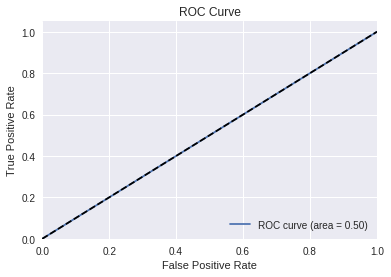

,score
precision,0.189 (+/- 0.035)
recall,0.583 (+/- 0.082)
f1,0.304 (+/- 0.019)
roc_auc,0.500 (+/- 0.000)


,test_score
precision,0.150
recall,0.429
f1,0.222
roc_auc,0.500


In [47]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

#### Logistic Regression classifier (best performance with string L2 regularization)

In [48]:
clf = LogisticRegression(solver='sag', n_jobs=-1, C=0.0000001)#, max_iter = 1000)
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: Th

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The ma

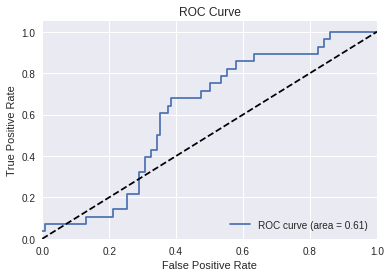

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.539 (+/- 0.039)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.608


In [49]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [50]:
logreg_bow_df = full_test_df.copy()

0    28
Name: y_pred, dtype: int64

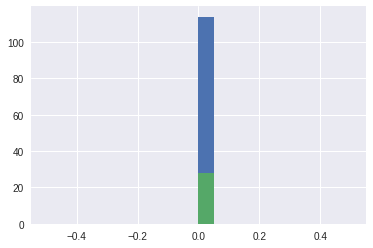

In [56]:
logreg_bow_df[logreg_bow_df.y_test == 0].y_pred.hist(bins=20)
logreg_bow_df[logreg_bow_df.y_test == 1].y_pred.hist(bins=20)
logreg_bow_df[logreg_bow_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

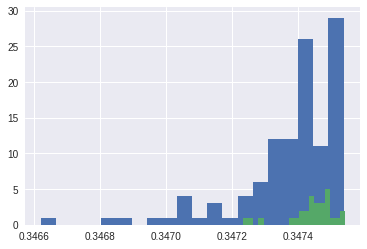

In [57]:
logreg_bow_df[logreg_bow_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg_bow_df[logreg_bow_df.y_test == 1].y_pred_proba.hist(bins=20)

In [59]:
logreg_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg_bow_df.y_test==1].sort_values('y_pred_proba', ascending=False)
logreg_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg_bow_df.y_test == 1)&(logreg_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg_bow_df.y_test == 1)&(logreg_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(logreg_bow_df.loc[i,'string'],'\n')
    
for id_subset in logreg_bow_df.sample_id[(logreg_bow_df.y_test == 1)&(logreg_bow_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
8,"hélas, ce dernier a été licencié.",1,1,0,0.347543,33.0,8.0
16,parmi les films les plus notables :,1,1,0,0.347536,35.0,7.0
6,selon une étude anglo-saxonne réalisée en 1977...,1,1,0,0.347516,105.0,21.0
5,"castella est une commune française, située d...",1,1,0,0.347504,106.0,21.0
20,les critics choice award du meilleur réalisat...,1,1,0,0.347492,179.0,29.0
9,il a été découvert empiriquement qu'un régime ...,1,1,0,0.347491,239.0,39.0
25,le maire du deuxième secteur de marseille est ...,1,1,0,0.347485,159.0,36.0
19,la première mondiale a eu lieu aux rencontres ...,1,1,0,0.347485,238.0,42.0
24,ce tome n'a pas été écrit par l.j smith. ce to...,1,1,0,0.347483,313.0,88.0
10,on ne peut la considérer sous le seul angle de...,1,1,0,0.347476,358.0,72.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


#### Decision Tree classifier

In [60]:
clf = DecisionTreeClassifier()#criterion='entropy', splitter='random', class_weight='balanced')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

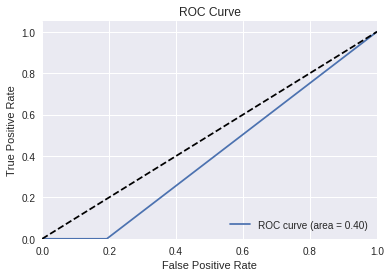

,score
precision,0.127 (+/- 0.035)
recall,0.096 (+/- 0.062)
f1,0.111 (+/- 0.044)
roc_auc,0.447 (+/- 0.022)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.404


In [61]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [62]:
dt_bow_df = full_test_df.copy()

0    28
Name: y_pred, dtype: int64

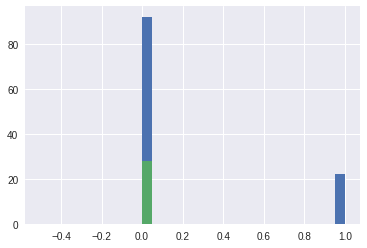

In [63]:
dt_bow_df[dt_bow_df.y_test == 0].y_pred.hist(bins=20)
dt_bow_df[dt_bow_df.y_test == 1].y_pred.hist(bins=20)
dt_bow_df[dt_bow_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

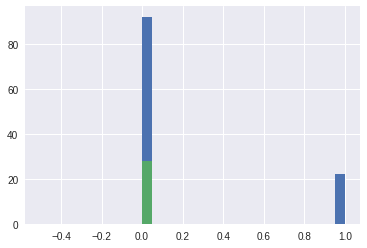

In [64]:
dt_bow_df[dt_bow_df.y_test == 0].y_pred_proba.hist(bins=20)
dt_bow_df[dt_bow_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [65]:
dt_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt_bow_df.y_test==1].sort_values('y_pred_proba', ascending=True)
dt_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(dt_bow_df.loc[i,'string'],'\n')
    
for id_subset in dt_bow_df.sample_id[(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
0,la vrt (communauté flamande) dispose depuis le...,1,1,0,0.0,582.0,129.0
25,le maire du deuxième secteur de marseille est ...,1,1,0,0.0,159.0,36.0
24,ce tome n'a pas été écrit par l.j smith. ce to...,1,1,0,0.0,313.0,88.0
23,projet de lancement d'une desserte voyageurs ...,1,1,0,0.0,441.0,91.0
22,le sous-secteur de jausiers du secteur forti...,1,1,0,0.0,978.0,201.0
21,le chef des gardes-serpents entre dans une piè...,1,1,0,0.0,372.0,92.0
20,les critics choice award du meilleur réalisat...,1,1,0,0.0,179.0,29.0
19,la première mondiale a eu lieu aux rencontres ...,1,1,0,0.0,238.0,42.0
18,l'empereur constance ii avait fait enlever du ...,1,1,0,0.0,1096.0,224.0
17,"un peu plus de vingt ans plus tard, l'as de pi...",1,1,0,0.0,558.0,101.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


Mean length of detected positive scores (character-wise and token-wise)

In [66]:
dt_bow_df.len[(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].mean()
dt_bow_df.len_tok[(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].mean()

nan

nan

#### Random forest

In [67]:
clf = RandomForestClassifier(n_estimators=2)#criterion='entropy', splitter='random', class_weight='balanced')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

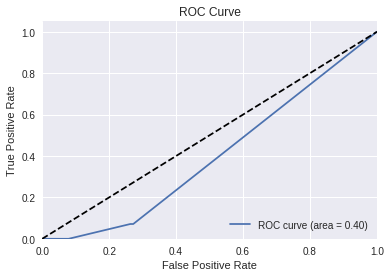

,score
precision,0.042 (+/- 0.000)
recall,0.018 (+/- 0.020)
f1,0.061 (+/- 0.025)
roc_auc,0.427 (+/- 0.076)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.397


In [68]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [69]:
rf_bow_df = full_test_df.copy()

0    28
Name: y_pred, dtype: int64

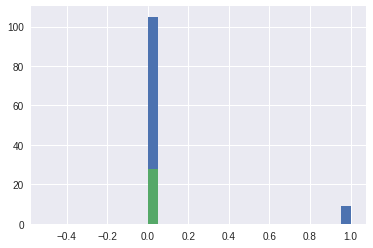

In [70]:
rf_bow_df[rf_bow_df.incoherence == 0].y_pred.hist(bins=20)
rf_bow_df[rf_bow_df.incoherence == 1].y_pred.hist(bins=20)
rf_bow_df[rf_bow_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

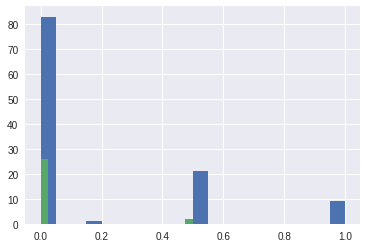

In [71]:
rf_bow_df[rf_bow_df.incoherence == 0].y_pred_proba.hist(bins=20)
rf_bow_df[rf_bow_df.incoherence == 1].y_pred_proba.hist(bins=20)

In [72]:
rf_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][rf_bow_df.y_test==1].sort_values('y_pred_proba', ascending=True)
rf_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(rf_bow_df.y_test == 1)&(rf_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = rf_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(rf_bow_df.y_test == 1)&(rf_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

for i in idx_list:
    print(rf_bow_df.loc[i,'string'],'\n')
    
for id_subset in rf_bow_df.sample_id[(rf_bow_df.y_test == 1)&(rf_bow_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
0,la vrt (communauté flamande) dispose depuis le...,1,1,0,0.0,582.0,129.0
25,le maire du deuxième secteur de marseille est ...,1,1,0,0.0,159.0,36.0
24,ce tome n'a pas été écrit par l.j smith. ce to...,1,1,0,0.0,313.0,88.0
22,le sous-secteur de jausiers du secteur forti...,1,1,0,0.0,978.0,201.0
21,le chef des gardes-serpents entre dans une piè...,1,1,0,0.0,372.0,92.0
20,les critics choice award du meilleur réalisat...,1,1,0,0.0,179.0,29.0
19,la première mondiale a eu lieu aux rencontres ...,1,1,0,0.0,238.0,42.0
18,l'empereur constance ii avait fait enlever du ...,1,1,0,0.0,1096.0,224.0
17,"un peu plus de vingt ans plus tard, l'as de pi...",1,1,0,0.0,558.0,101.0
16,parmi les films les plus notables :,1,1,0,0.0,35.0,7.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


Mean length of detected positive scores (character-wise and token-wise)

In [73]:
rf_bow_df.len[(rf_bow_df.y_test == 1)&(rf_bow_df.y_pred == 1)].mean()
rf_bow_df.len_tok[(rf_bow_df.y_test == 1)&(rf_bow_df.y_pred == 1)].mean()

nan

nan

## Method 2: TF-IDF

In [74]:
%%time
#vectorizer = TfidfVectorizer(max_features=4096)
#vectorizer.fit(txt_input)
##pickle.dump(vectorizer, open("vectorizer_tfidf.p", "wb"))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.58 µs


In [75]:
vectorizer = pickle.load(open("vectorizer_tfidf.p", "rb"))

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [76]:
print('Voc length: {:,}'.format(len(vectorizer.vocabulary_)))

X_train = vectorizer.transform(df_train.string).toarray()
X_test = vectorizer.transform(df_test.string).toarray()

y_train = df_train.incoherence.values
y_test = df_test.incoherence.values

Voc length: 4,096


#### Logistic Regression classifier

In [77]:
clf = LogisticRegression(solver='sag', n_jobs=-1, C=0.0000001) #,  The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: Th

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The ma

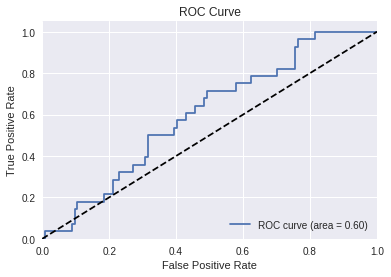

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.529 (+/- 0.036)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.602


In [78]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [79]:
logreg_tfidf_df = full_test_df.copy()

0    28
Name: y_pred, dtype: int64

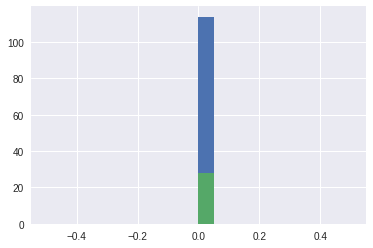

In [80]:
logreg_tfidf_df[logreg_tfidf_df.y_test == 0].y_pred.hist(bins=20)
logreg_tfidf_df[logreg_tfidf_df.y_test == 1].y_pred.hist(bins=20)
logreg_tfidf_df[logreg_tfidf_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

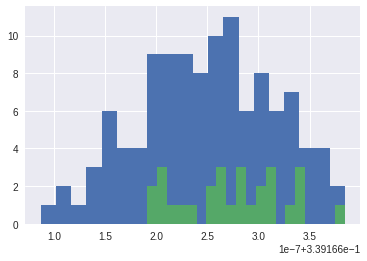

In [81]:
logreg_tfidf_df[logreg_tfidf_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg_tfidf_df[logreg_tfidf_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [82]:
logreg_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg_tfidf_df.y_test==1].sort_values('y_pred_proba', ascending=False)
logreg_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg_tfidf_df.y_test == 1)&(logreg_tfidf_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg_tfidf_df.y_test == 1)&(logreg_tfidf_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(logreg_tfidf_df.loc[i,'string'],'\n')
    
for id_subset in logreg_tfidf_df.sample_id[(logreg_tfidf_df.y_test == 1)&(logreg_tfidf_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
8,"hélas, ce dernier a été licencié.",1,1,0,0.339166,33.0,8.0
3,ĉu vi demandis vian patron? = as-tu demandé ...,1,1,0,0.339166,418.0,103.0
16,parmi les films les plus notables :,1,1,0,0.339166,35.0,7.0
24,ce tome n'a pas été écrit par l.j smith. ce to...,1,1,0,0.339166,313.0,88.0
6,selon une étude anglo-saxonne réalisée en 1977...,1,1,0,0.339166,105.0,21.0
9,il a été découvert empiriquement qu'un régime ...,1,1,0,0.339166,239.0,39.0
25,le maire du deuxième secteur de marseille est ...,1,1,0,0.339166,159.0,36.0
19,la première mondiale a eu lieu aux rencontres ...,1,1,0,0.339166,238.0,42.0
0,la vrt (communauté flamande) dispose depuis le...,1,1,0,0.339166,582.0,129.0
13,"aux municipales de 1995, à l'instigation de la...",1,1,0,0.339166,220.0,45.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


Mean length of detected positive scores (character-wise and token-wise)

In [83]:
logreg_tfidf_df.len[(dt_bow_df.y_test == 1)&(logreg_tfidf_df.y_pred == 1)].mean()
logreg_tfidf_df.len_tok[(dt_bow_df.y_test == 1)&(logreg_tfidf_df.y_pred == 1)].mean()

nan

nan

#### Decision tree classifier

In [84]:
clf = DecisionTreeClassifier(criterion='entropy', splitter='random')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

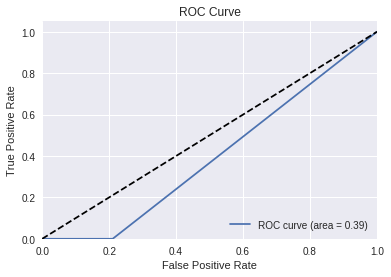

,score
precision,0.093 (+/- 0.053)
recall,0.078 (+/- 0.038)
f1,0.071 (+/- 0.045)
roc_auc,0.418 (+/- 0.034)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.395


In [85]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [86]:
dt_tfidf_df = full_test_df.copy()

0    28
Name: y_pred, dtype: int64

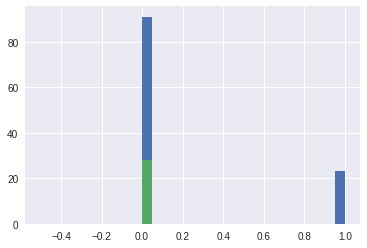

In [87]:
dt_tfidf_df[dt_tfidf_df.incoherence == 0].y_pred.hist(bins=20)
dt_tfidf_df[dt_tfidf_df.incoherence == 1].y_pred.hist(bins=20)
dt_tfidf_df[dt_tfidf_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

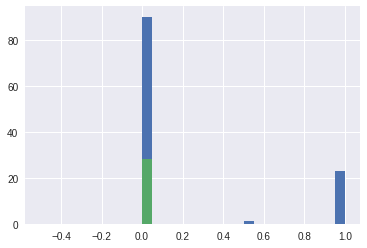

In [88]:
dt_tfidf_df[dt_tfidf_df.incoherence == 0].y_pred_proba.hist(bins=20)
dt_tfidf_df[dt_tfidf_df.incoherence == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [89]:
dt_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt_tfidf_df.y_test==1].sort_values('y_pred_proba', ascending=False)
dt_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(dt_tfidf_df.loc[i,'string'],'\n')
    
for id_subset in dt_tfidf_df.sample_id[(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
0,la vrt (communauté flamande) dispose depuis le...,1,1,0,0.0,582.0,129.0
1,"la première guerre mondiale, déclenchée par un...",1,1,0,0.0,483.0,91.0
26,cette abside est surmontée d'une très belle fr...,1,1,0,0.0,364.0,72.0
25,le maire du deuxième secteur de marseille est ...,1,1,0,0.0,159.0,36.0
24,ce tome n'a pas été écrit par l.j smith. ce to...,1,1,0,0.0,313.0,88.0
23,projet de lancement d'une desserte voyageurs ...,1,1,0,0.0,441.0,91.0
22,le sous-secteur de jausiers du secteur forti...,1,1,0,0.0,978.0,201.0
21,le chef des gardes-serpents entre dans une piè...,1,1,0,0.0,372.0,92.0
20,les critics choice award du meilleur réalisat...,1,1,0,0.0,179.0,29.0
19,la première mondiale a eu lieu aux rencontres ...,1,1,0,0.0,238.0,42.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


Mean length of detected positive scores (character-wise and token-wise)

In [90]:
dt_tfidf_df.len[(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].mean()
dt_tfidf_df.len_tok[(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].mean()

nan

nan

## Method 3: Mean vectors

Function for getting mean vector of each string

In [91]:
def w2v_extractor(df, model):
    
    token_list = []
    sentence_list = []
    
    for i in range(0, df.shape[0]): # for each string
        g = 0
        for token in re.findall(string_pattern, df.loc[i,'string']): # for each token of the string
            g += 1
            if token in model.wv.vocab:
                token_list.append(np.reshape(model.wv.word_vec(token), (1, model.vector_size)))
                
            else:
                continue
        
        string_matrix = np.vstack(token_list)
        
        string_average = string_matrix.mean(axis=0)
        
        sentence_list.append(string_average)
        token_list = []
    
    string_ave_matrix = np.vstack(sentence_list)
    
    list_col = [] # generate columns labels for each of the dimensions
    for i in range(0, model.vector_size):
        list_col.append('dim_{}'.format(i))

    dim_df = pd.DataFrame(string_ave_matrix)
    dim_df.columns = list_col
    
    return dim_df

### 3.1 Vector size 100

In [92]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')

dim_df_train = w2v_extractor(df_train, model)
dim_df_test = w2v_extractor(df_test, model)

temp_df_train = pd.concat([df_train.copy(), dim_df_train], axis=1)
temp_df_test = pd.concat([df_test.copy(), dim_df_test], axis=1)

X_train = temp_df_train[temp_df_train.columns[-model.vector_size:]].values.copy()
X_test = temp_df_test[temp_df_test.columns[-model.vector_size:]].values.copy()

y_train = temp_df_train.incoherence.values.copy()
y_test = temp_df_test.incoherence.values.copy()

#### Logistic regression

In [93]:
clf = LogisticRegression(solver='sag', n_jobs=-1, C=0.000000001)
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/class

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


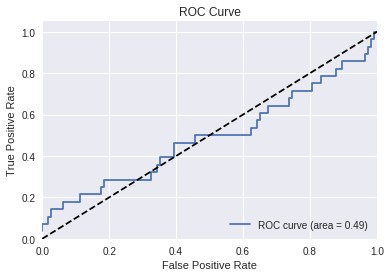

100

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.465 (+/- 0.037)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.492


In [94]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [95]:
logreg100_mean_df = full_test_df.copy()

0    28
Name: y_pred, dtype: int64

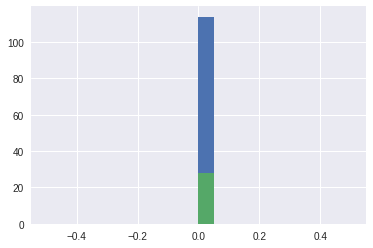

In [96]:
logreg100_mean_df[logreg100_mean_df.y_test == 0].y_pred.hist(bins=20)
logreg100_mean_df[logreg100_mean_df.y_test == 1].y_pred.hist(bins=20)
logreg100_mean_df[logreg100_mean_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

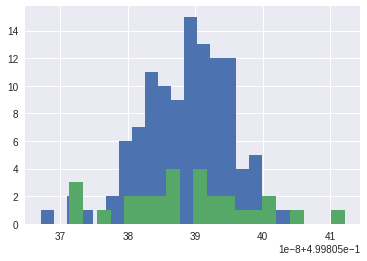

In [97]:
logreg100_mean_df[logreg100_mean_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg100_mean_df[logreg100_mean_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [98]:
logreg100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg100_mean_df.y_test==1].sort_values('y_pred_proba', ascending=False)
logreg100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg100_mean_df.y_test == 1)&(logreg100_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg100_mean_df.y_test == 1)&(logreg100_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(logreg100_mean_df.loc[i,'string'],'\n')
    
for id_subset in logreg100_mean_df.sample_id[(logreg100_mean_df.y_test == 1)&(logreg100_mean_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
9,il a été découvert empiriquement qu'un régime ...,1,1,0,0.499805,239.0,39.0
8,"hélas, ce dernier a été licencié.",1,1,0,0.499805,33.0,8.0
27,en commun avec la pièce de deux livres sterlin...,1,1,0,0.499805,508.0,98.0
18,l'empereur constance ii avait fait enlever du ...,1,1,0,0.499805,1096.0,224.0
1,"la première guerre mondiale, déclenchée par un...",1,1,0,0.499805,483.0,91.0
14,le projet ol land est contesté principalement ...,1,1,0,0.499805,471.0,93.0
10,on ne peut la considérer sous le seul angle de...,1,1,0,0.499805,358.0,72.0
17,"un peu plus de vingt ans plus tard, l'as de pi...",1,1,0,0.499805,558.0,101.0
3,ĉu vi demandis vian patron? = as-tu demandé ...,1,1,0,0.499805,418.0,103.0
12,"en juillet 1950, il est nommé curé de la paroi...",1,1,0,0.499805,1163.0,228.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


#### Decision tree classifier

In [99]:
clf = DecisionTreeClassifier()
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

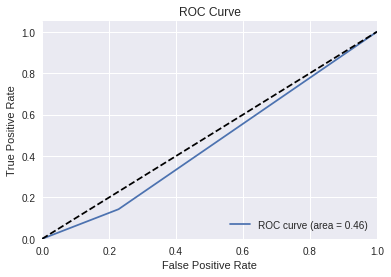

100

,score
precision,0.185 (+/- 0.050)
recall,0.139 (+/- 0.021)
f1,0.142 (+/- 0.050)
roc_auc,0.451 (+/- 0.023)


,test_score
precision,0.133
recall,0.143
f1,0.138
roc_auc,0.457


In [100]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [101]:
dt100_mean_df = full_test_df.copy()

0    24
1     4
Name: y_pred, dtype: int64

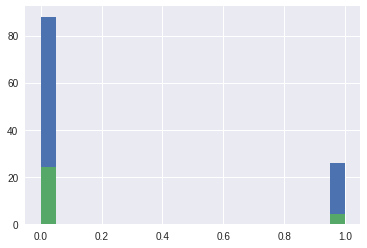

In [102]:
dt100_mean_df[dt100_mean_df.y_test == 0].y_pred.hist(bins=20)
dt100_mean_df[dt100_mean_df.y_test == 1].y_pred.hist(bins=20)
dt100_mean_df[dt100_mean_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

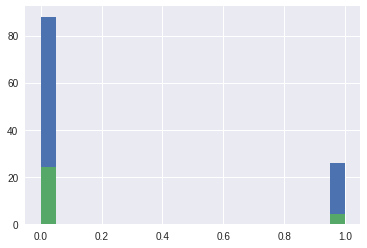

In [103]:
dt100_mean_df[dt100_mean_df.y_test == 0].y_pred_proba.hist(bins=20)
dt100_mean_df[dt100_mean_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [104]:
dt100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt100_mean_df.y_test==1].sort_values('y_pred_proba', ascending=False)
dt100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt100_mean_df.y_test == 1)&(dt100_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt100_mean_df.y_test == 1)&(dt100_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(dt100_mean_df.loc[i,'string'],'\n')
    
for id_subset in dt100_mean_df.sample_id[(dt100_mean_df.y_test == 1)&(dt100_mean_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
24,ce tome n'a pas été écrit par l.j smith. ce to...,1,1,1,1.0,313.0,88.0
7,les z 4900 et les z 4500 constituent la prem...,1,1,1,1.0,362.0,73.0
13,"aux municipales de 1995, à l'instigation de la...",1,1,1,1.0,220.0,45.0
16,parmi les films les plus notables :,1,1,1,1.0,35.0,7.0
0,la vrt (communauté flamande) dispose depuis le...,1,1,0,0.0,582.0,129.0
15,"le convertisseur statique, défini comme un red...",1,1,0,0.0,448.0,89.0
26,cette abside est surmontée d'une très belle fr...,1,1,0,0.0,364.0,72.0
25,le maire du deuxième secteur de marseille est ...,1,1,0,0.0,159.0,36.0
23,projet de lancement d'une desserte voyageurs ...,1,1,0,0.0,441.0,91.0
22,le sous-secteur de jausiers du secteur forti...,1,1,0,0.0,978.0,201.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
7,les z 4900 et les z 4500 constituent la prem...,1,1,1,1.0,362.0,73.0
13,"aux municipales de 1995, à l'instigation de la...",1,1,1,1.0,220.0,45.0
16,parmi les films les plus notables :,1,1,1,1.0,35.0,7.0
24,ce tome n'a pas été écrit par l.j smith. ce to...,1,1,1,1.0,313.0,88.0


les  z 4900  et les z 4500 constituent la première série de 30 automotrices électriques e abd 1 à 30 de la compagnie du midi. elles se caractérisent par leur courant d'alimentation unique en france, alternatif  12 kv  monophasé, à la fréquence de  16⅔ hz , l'option technique propre à la compagnie du midi qui a été retenue en 1911 pour électrifier son réseau. * 

aux municipales de 1995, à l'instigation de laurent fabius, il est le cadidat socialiste à rouen et emporte la mairie au dauphin de jean lecanuet, françois gautier.  il est également professeur associé à l'ipag de rouen. 

parmi les films les plus notables : 

ce tome n'a pas été écrit par l.j smith. ce tome n'a pas été écrit par l.j smith. ce huitième tome est paru le 6 février 2013. comme les précédents, il n'a pas été écrit par l.j smith. un tome 9 est sorti le 3 juillet 2013. comme les livres de "journal d'un vampire" précédents, il n'a pas été écrit par l.j smith 

comparison link: 	 https://fr.wikipedia.org/w/index.php?di

### 3.2 Vector size 300

In [105]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')

dim_df_train = w2v_extractor(df_train, model)
dim_df_test = w2v_extractor(df_test, model)

temp_df_train = pd.concat([df_train.copy(), dim_df_train], axis=1)
temp_df_test = pd.concat([df_test.copy(), dim_df_test], axis=1)

X_train = temp_df_train[temp_df_train.columns[-model.vector_size:]].values.copy()
X_test = temp_df_test[temp_df_test.columns[-model.vector_size:]].values.copy()

y_train = temp_df_train.incoherence.values.copy()
y_test = temp_df_test.incoherence.values.copy()

#### Logistic regression

In [106]:
clf = LogisticRegression(solver='sag', n_jobs=-1, C=0.000000001)
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/class

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


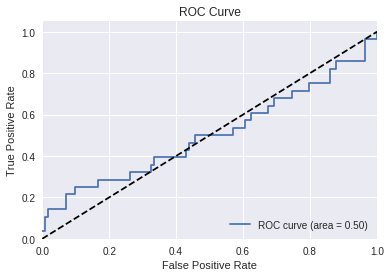

300

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.457 (+/- 0.018)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.504


In [107]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [108]:
logreg300_mean_df = full_test_df.copy()

0    28
Name: y_pred, dtype: int64

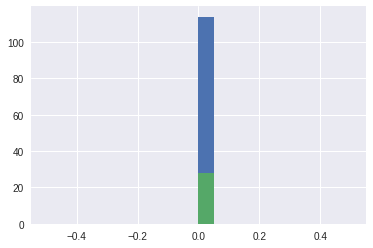

In [109]:
logreg300_mean_df[logreg300_mean_df.y_test == 0].y_pred.hist(bins=20)
logreg300_mean_df[logreg300_mean_df.y_test == 1].y_pred.hist(bins=20)
logreg300_mean_df[logreg300_mean_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

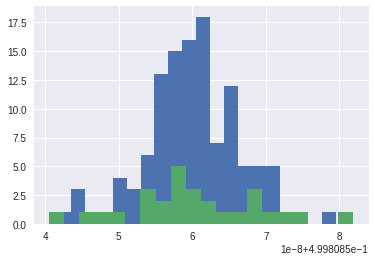

In [110]:
logreg300_mean_df[logreg300_mean_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg300_mean_df[logreg300_mean_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [111]:
logreg300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg300_mean_df.y_test==1].sort_values('y_pred_proba', ascending=True)
logreg300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg300_mean_df.y_test == 1)&(logreg300_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg300_mean_df.y_test == 1)&(logreg300_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()
for i in idx_list:
    print(logreg300_mean_df.loc[i,'string'],'\n')
    
for id_subset in logreg300_mean_df.sample_id[(logreg300_mean_df.y_test == 1)&(logreg300_mean_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
19,la première mondiale a eu lieu aux rencontres ...,1,1,0,0.499809,238.0,42.0
2,il est classé seizième meilleur film de tous l...,1,1,0,0.499809,220.0,54.0
25,le maire du deuxième secteur de marseille est ...,1,1,0,0.499809,159.0,36.0
16,parmi les films les plus notables :,1,1,0,0.499809,35.0,7.0
13,"aux municipales de 1995, à l'instigation de la...",1,1,0,0.499809,220.0,45.0
11,"c'est en 2006 que marc mercier, en voulant res...",1,1,0,0.499809,256.0,53.0
15,"le convertisseur statique, défini comme un red...",1,1,0,0.499809,448.0,89.0
22,le sous-secteur de jausiers du secteur forti...,1,1,0,0.499809,978.0,201.0
21,le chef des gardes-serpents entre dans une piè...,1,1,0,0.499809,372.0,92.0
4,l'ordre des hoshannot pour les pluies ainsi ...,1,1,0,0.499809,592.0,127.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


#### Decision Tree classifier

In [112]:
clf = DecisionTreeClassifier()
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

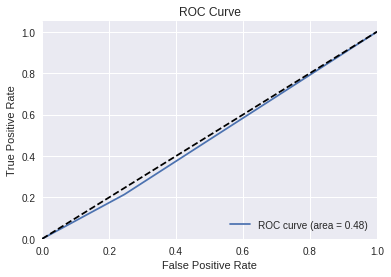

300

,score
precision,0.149 (+/- 0.046)
recall,0.122 (+/- 0.064)
f1,0.180 (+/- 0.062)
roc_auc,0.444 (+/- 0.048)


,test_score
precision,0.176
recall,0.214
f1,0.194
roc_auc,0.484


In [113]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [114]:
dt300_mean_df = full_test_df.copy()

0    22
1     6
Name: y_pred, dtype: int64

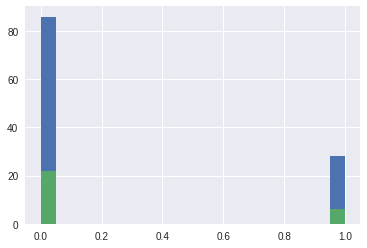

In [115]:
dt300_mean_df[dt300_mean_df.y_test == 0].y_pred.hist(bins=20)
dt300_mean_df[dt300_mean_df.y_test == 1].y_pred.hist(bins=20)
dt300_mean_df[dt300_mean_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

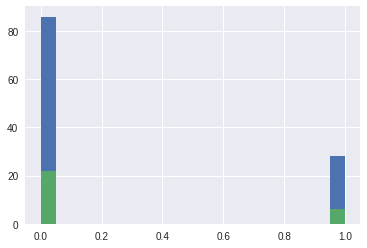

In [116]:
dt300_mean_df[dt300_mean_df.y_test == 0].y_pred_proba.hist(bins=20)
dt300_mean_df[dt300_mean_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [117]:
dt300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt300_mean_df.y_test==1].sort_values('y_pred_proba', ascending=True)
dt300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt300_mean_df.y_test == 1)&(dt300_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt300_mean_df.y_test == 1)&(dt300_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

for i in idx_list:
    print(dt300_mean_df.loc[i,'string'],'\n')
    
for id_subset in dt300_mean_df.sample_id[(dt300_mean_df.y_test == 1)&(dt300_mean_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
0,la vrt (communauté flamande) dispose depuis le...,1,1,0,0.0,582.0,129.0
25,le maire du deuxième secteur de marseille est ...,1,1,0,0.0,159.0,36.0
24,ce tome n'a pas été écrit par l.j smith. ce to...,1,1,0,0.0,313.0,88.0
21,le chef des gardes-serpents entre dans une piè...,1,1,0,0.0,372.0,92.0
19,la première mondiale a eu lieu aux rencontres ...,1,1,0,0.0,238.0,42.0
17,"un peu plus de vingt ans plus tard, l'as de pi...",1,1,0,0.0,558.0,101.0
16,parmi les films les plus notables :,1,1,0,0.0,35.0,7.0
15,"le convertisseur statique, défini comme un red...",1,1,0,0.0,448.0,89.0
14,le projet ol land est contesté principalement ...,1,1,0,0.0,471.0,93.0
26,cette abside est surmontée d'une très belle fr...,1,1,0,0.0,364.0,72.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
8,"hélas, ce dernier a été licencié.",1,1,1,1.0,33.0,8.0
10,on ne peut la considérer sous le seul angle de...,1,1,1,1.0,358.0,72.0
18,l'empereur constance ii avait fait enlever du ...,1,1,1,1.0,1096.0,224.0
20,les critics choice award du meilleur réalisat...,1,1,1,1.0,179.0,29.0
22,le sous-secteur de jausiers du secteur forti...,1,1,1,1.0,978.0,201.0
23,projet de lancement d'une desserte voyageurs ...,1,1,1,1.0,441.0,91.0


hélas, ce dernier a été licencié. 

on ne peut la considérer sous le seul angle de la vulgarité : mieux vaut constater que celle-ci s'en trouve notablement atténuée par rapport à des expressions courantes se rapportant aux excréments, en usage dès les origines du français, ou en regard d'expressions du genre « mince ! », que l'on se plaît souvent à considérer comme des substituts distingués. 

l'empereur constance ii avait fait enlever du sénat l'autel de la victoire ; julien l'y replaça, gratien l'en retira définitivement. la victoire continue à figurer sur les monuments et les monnaies, purifiée par l'alliance avec le monogramme du christ. honorius et valentinien iii tiennent d'une main la victoire, de l'autre le  labarum .  victoria augustorum  se retrouve sur les monnaies du dernier empereur romain d'occident, romulus augustule. même sous justinien, semble-t-il, le symbole de la victoire reste lié à la personne de l'empereur. dépourvu de tout caractère cultuel, ce fétiche n'a cepen

## Method 4: skig-gram model

In [118]:
def scores_generator(df_train, df_test, pair_fn):
    
    df_test_temp = df_test.copy()
    df_test_temp = df_test_temp.reset_index()

    df_scores = pd.DataFrame(index=df_train.index, columns=['score'])
    df_scores_test = pd.DataFrame(index=df_test_temp.index, columns=['score'])

    for i in range(0, df_train.shape[0]):
        df_scores.loc[i,'string'] = df_train.loc[i,'string']
        df_scores.loc[i,'score'] = score_sentence_sg(pair_fn, model, re.findall(string_pattern, df_train.loc[i,'string']))
        
    X_train = df_scores.score
    y_train = df_train.incoherence
    
    for i in range(0, df_test_temp.shape[0]):
        df_scores_test.loc[i,'string'] = df_test_temp.loc[i,'string']
        df_scores_test.loc[i,'score'] = score_sentence_sg(pair_fn, model, re.findall(string_pattern, df_test_temp.loc[i,'string']))
        
    X_test = df_scores_test.score
    y_test = df_test_temp.incoherence
    
    return df_scores, X_train, y_train, df_scores_test, X_test, y_test

In [119]:
def score_sentence_sg(score_sg_fn, model, sentence, work=None):
    """
    Obtain likelihood score for a single sentence in a fitted skip-gram representaion.

    The sentence is a list of Vocab objects (or None, when the corresponding
    word is not in the vocabulary). Called internally from `Word2Vec.score()`.

    This is the non-optimized, Python version. If you have cython installed, gensim
    will use the optimized version from word2vec_inner instead.
    
    """

    log_prob_sentence = 0.0
    if model.negative:
        raise RuntimeError("scoring is only available for HS=True")

    word_vocabs = [model.wv.vocab[w] for w in sentence if w in model.wv.vocab]
    for pos, word in enumerate(word_vocabs):
        if word is None:
            continue  # OOV word in the input sentence => skip

        # now go over all words from the window, predicting each one in turn
        start = max(0, pos - model.window)
        for pos2, word2 in enumerate(word_vocabs[start : pos + model.window + 1], start):
            # don't train on OOV words and on the `word` itself
            if word2 is not None and pos2 != pos:
                log_prob_sentence += score_sg_fn(model, word, word2)

    return log_prob_sentence


def score_sg_pair_original(model, word, word2):
    l1 = model.wv.syn0[word2.index]
    l2a = deepcopy(model.syn1[word.point])  # 2d matrix, codelen x layer1_size
    sgn = (-1.0)**word.code  # ch function, 0-> 1, 1 -> -1
    lprob = -np.log(1.0 + np.exp(-sgn*np.dot(l1, l2a.T)))
    return sum(lprob)

def score_sg_pair(model, word, word2):
    #print(word, word2)
    l1 = model.wv.syn0[word2.index]
    print('a >', word.point.shape, word.code.shape)
    l2 = deepcopy(model.syn1[word.point])  # 2d matrix, codelen x layer1_size

    #assert l1.shape == l2.shape
    lprob = l2 * l1
    print('b >', lprob.shape)
    return lprob

### 4.1 Vector size 100

In [120]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')
df_scores, X_train, y_train, df_scores_test, X_test, y_test = scores_generator(df_train, df_test, score_sg_pair_original)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

/home/dp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


#### Logistic regression

In [121]:
clf = LogisticRegression()
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/class

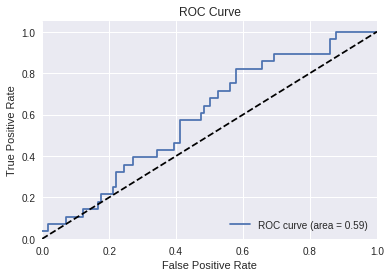

100

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.558 (+/- 0.052)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.595


In [122]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [123]:
logreg100_sg_df = full_test_df.copy()

0    28
Name: y_pred, dtype: int64

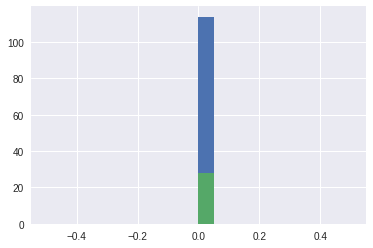

In [124]:
logreg100_sg_df[logreg100_sg_df.y_test == 0].y_pred.hist(bins=20)
logreg100_sg_df[logreg100_sg_df.y_test == 1].y_pred.hist(bins=20)
logreg100_sg_df[logreg100_sg_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

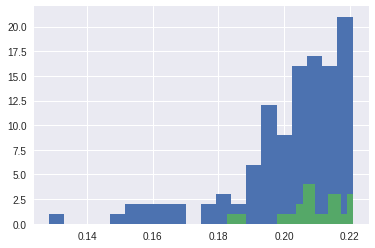

In [125]:
logreg100_sg_df[logreg100_sg_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg100_sg_df[logreg100_sg_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [126]:
logreg100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg100_sg_df.y_test==1].sort_values('y_pred_proba', ascending=True)
logreg100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg100_sg_df.y_test == 1)&(logreg100_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg100_sg_df.y_test == 1)&(logreg100_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

for i in idx_list:
    print(logreg100_sg_df.loc[i,'string'],'\n')
    
for id_subset in logreg100_sg_df.sample_id[(logreg100_sg_df.y_test == 1)&(logreg100_sg_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
12,"en juillet 1950, il est nommé curé de la paroi...",1,1,0,0.182466,1163.0,228.0
18,l'empereur constance ii avait fait enlever du ...,1,1,0,0.186208,1096.0,224.0
22,le sous-secteur de jausiers du secteur forti...,1,1,0,0.187201,978.0,201.0
0,la vrt (communauté flamande) dispose depuis le...,1,1,0,0.198013,582.0,129.0
4,l'ordre des hoshannot pour les pluies ainsi ...,1,1,0,0.201529,592.0,127.0
17,"un peu plus de vingt ans plus tard, l'as de pi...",1,1,0,0.203442,558.0,101.0
3,ĉu vi demandis vian patron? = as-tu demandé ...,1,1,0,0.204105,418.0,103.0
27,en commun avec la pièce de deux livres sterlin...,1,1,0,0.205230,508.0,98.0
14,le projet ol land est contesté principalement ...,1,1,0,0.206186,471.0,93.0
1,"la première guerre mondiale, déclenchée par un...",1,1,0,0.206716,483.0,91.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


#### Decision tree classifier

In [127]:
clf = DecisionTreeClassifier(max_depth=1)#,criterion='entropy')#, splitter='random', class_weight='balanced')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/class

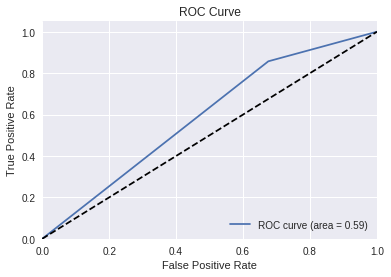

100

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.500 (+/- 0.024)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.591


In [128]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [129]:
dt100_sg_df = full_test_df.copy()

0    28
Name: y_pred, dtype: int64

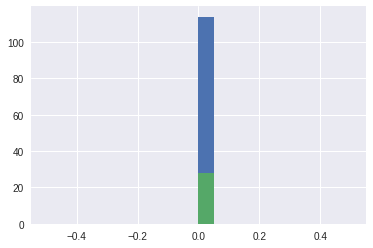

In [130]:
dt100_sg_df[dt100_sg_df.y_test == 0].y_pred.hist(bins=20)
dt100_sg_df[dt100_sg_df.y_test == 1].y_pred.hist(bins=20)
dt100_sg_df[dt100_sg_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

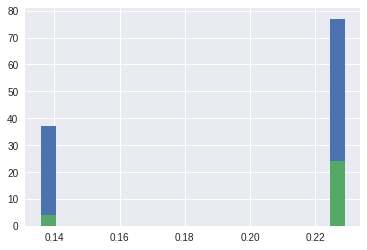

In [131]:
dt100_sg_df[dt100_sg_df.y_test == 0].y_pred_proba.hist(bins=20)
dt100_sg_df[dt100_sg_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [132]:
dt100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt100_sg_df.y_test==1].sort_values('y_pred_proba', ascending=False)
dt100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt100_sg_df.y_test == 1)&(dt100_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt100_sg_df.y_test == 1)&(dt100_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

for i in idx_list:
    print(dt100_sg_df.loc[i,'string'],'\n')
    
for id_subset in dt100_sg_df.sample_id[(dt100_sg_df.y_test == 1)&(dt100_sg_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
14,le projet ol land est contesté principalement ...,1,1,0,0.229064,471.0,93.0
13,"aux municipales de 1995, à l'instigation de la...",1,1,0,0.229064,220.0,45.0
26,cette abside est surmontée d'une très belle fr...,1,1,0,0.229064,364.0,72.0
25,le maire du deuxième secteur de marseille est ...,1,1,0,0.229064,159.0,36.0
24,ce tome n'a pas été écrit par l.j smith. ce to...,1,1,0,0.229064,313.0,88.0
23,projet de lancement d'une desserte voyageurs ...,1,1,0,0.229064,441.0,91.0
21,le chef des gardes-serpents entre dans une piè...,1,1,0,0.229064,372.0,92.0
20,les critics choice award du meilleur réalisat...,1,1,0,0.229064,179.0,29.0
19,la première mondiale a eu lieu aux rencontres ...,1,1,0,0.229064,238.0,42.0
17,"un peu plus de vingt ans plus tard, l'as de pi...",1,1,0,0.229064,558.0,101.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


### 4.2 Vector size 300

In [133]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')
df_scores, X_train, y_train, df_scores_test, X_test, y_test = scores_generator(df_train, df_test, score_sg_pair_original)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

/home/dp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


#### Logistic regression

In [134]:
clf = LogisticRegression()
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/class

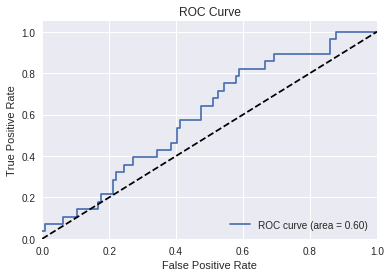

300

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.555 (+/- 0.056)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.597


In [135]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [136]:
logreg300_sg_df = full_test_df.copy()

0    28
Name: y_pred, dtype: int64

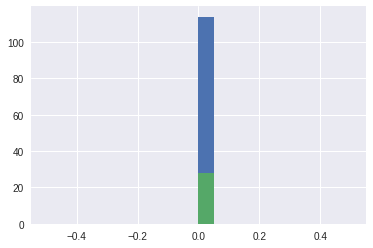

In [137]:
logreg300_sg_df[logreg300_sg_df.y_test == 0].y_pred.hist(bins=20)
logreg300_sg_df[logreg300_sg_df.y_test == 1].y_pred.hist(bins=20)
logreg300_sg_df[logreg300_sg_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

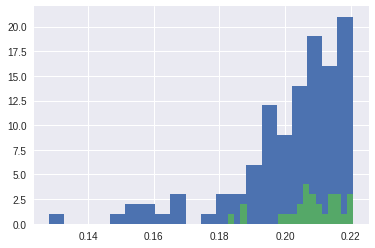

In [138]:
logreg300_sg_df[logreg300_sg_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg300_sg_df[logreg300_sg_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [139]:
logreg300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg300_sg_df.y_test==1].sort_values('y_pred_proba', ascending=False)
logreg300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg300_sg_df.y_test == 1)&(logreg300_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = logreg300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg300_sg_df.y_test == 1)&(logreg300_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

for i in idx_list:
    print(logreg300_sg_df.loc[i,'string'],'\n')
    
for id_subset in logreg300_sg_df.sample_id[(logreg300_sg_df.y_test == 1)&(logreg300_sg_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
16,parmi les films les plus notables :,1,1,0,0.220864,35.0,7.0
8,"hélas, ce dernier a été licencié.",1,1,0,0.220550,33.0,8.0
5,"castella est une commune française, située d...",1,1,0,0.219114,106.0,21.0
6,selon une étude anglo-saxonne réalisée en 1977...,1,1,0,0.217997,105.0,21.0
20,les critics choice award du meilleur réalisat...,1,1,0,0.216774,179.0,29.0
25,le maire du deuxième secteur de marseille est ...,1,1,0,0.216066,159.0,36.0
13,"aux municipales de 1995, à l'instigation de la...",1,1,0,0.215134,220.0,45.0
19,la première mondiale a eu lieu aux rencontres ...,1,1,0,0.215044,238.0,42.0
9,il a été découvert empiriquement qu'un régime ...,1,1,0,0.214774,239.0,39.0
2,il est classé seizième meilleur film de tous l...,1,1,0,0.213578,220.0,54.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


#### Decision tree

In [140]:
clf = DecisionTreeClassifier()
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

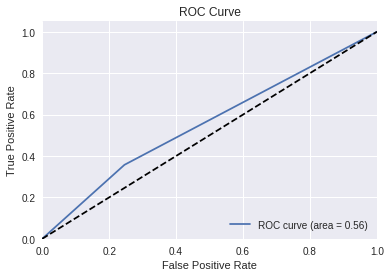

300

,score
precision,0.163 (+/- 0.050)
recall,0.157 (+/- 0.057)
f1,0.147 (+/- 0.031)
roc_auc,0.473 (+/- 0.031)


,test_score
precision,0.263
recall,0.357
f1,0.303
roc_auc,0.556


In [141]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [142]:
dt300_sg_df = full_test_df.copy()

0    18
1    10
Name: y_pred, dtype: int64

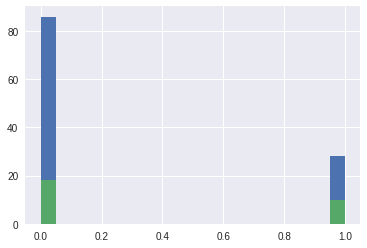

In [143]:
dt300_sg_df[dt300_sg_df.y_test == 0].y_pred.hist(bins=20)
dt300_sg_df[dt300_sg_df.y_test == 1].y_pred.hist(bins=20)
dt300_sg_df[dt300_sg_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

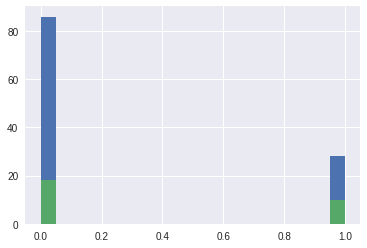

In [144]:
dt300_sg_df[dt300_sg_df.y_test == 0].y_pred_proba.hist(bins=20)
dt300_sg_df[dt300_sg_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [145]:
dt300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt300_sg_df.y_test==1].sort_values('y_pred_proba', ascending=False)
dt300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt300_sg_df.y_test == 1)&(dt300_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
idx_list = dt300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt300_sg_df.y_test == 1)&(dt300_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False).index.values.tolist()

for i in idx_list:
    print(dt300_sg_df.loc[i,'string'],'\n')

for id_subset in dt300_sg_df.sample_id[(dt300_sg_df.y_test == 1)&(dt300_sg_df.y_pred == 1)].tolist():
    print('comparison link:', '\t', 'https://fr.wikipedia.org/w/index.php?diff=' + str(df_XY.id[df_XY.sample_id==id_subset].values[0])+'&oldid='+str(int(df_XY.parentid[df_XY.sample_id==id_subset].values[0])),'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
14,le projet ol land est contesté principalement ...,1,1,1,1.0,471.0,93.0
23,projet de lancement d'une desserte voyageurs ...,1,1,1,1.0,441.0,91.0
15,"le convertisseur statique, défini comme un red...",1,1,1,1.0,448.0,89.0
13,"aux municipales de 1995, à l'instigation de la...",1,1,1,1.0,220.0,45.0
11,"c'est en 2006 que marc mercier, en voulant res...",1,1,1,1.0,256.0,53.0
10,on ne peut la considérer sous le seul angle de...,1,1,1,1.0,358.0,72.0
22,le sous-secteur de jausiers du secteur forti...,1,1,1,1.0,978.0,201.0
4,l'ordre des hoshannot pour les pluies ainsi ...,1,1,1,1.0,592.0,127.0
3,ĉu vi demandis vian patron? = as-tu demandé ...,1,1,1,1.0,418.0,103.0
16,parmi les films les plus notables :,1,1,1,1.0,35.0,7.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
3,ĉu vi demandis vian patron? = as-tu demandé ...,1,1,1,1.0,418.0,103.0
4,l'ordre des hoshannot pour les pluies ainsi ...,1,1,1,1.0,592.0,127.0
10,on ne peut la considérer sous le seul angle de...,1,1,1,1.0,358.0,72.0
11,"c'est en 2006 que marc mercier, en voulant res...",1,1,1,1.0,256.0,53.0
13,"aux municipales de 1995, à l'instigation de la...",1,1,1,1.0,220.0,45.0
14,le projet ol land est contesté principalement ...,1,1,1,1.0,471.0,93.0
15,"le convertisseur statique, défini comme un red...",1,1,1,1.0,448.0,89.0
16,parmi les films les plus notables :,1,1,1,1.0,35.0,7.0
22,le sous-secteur de jausiers du secteur forti...,1,1,1,1.0,978.0,201.0
23,projet de lancement d'une desserte voyageurs ...,1,1,1,1.0,441.0,91.0


 ĉu vi demandis vian patron?  = as-tu demandé à un de tes parents? (à l'un ou à l'autre)  ĉu vi demandis vian patriĉon/virpatron?  = as-tu demandé à ton père?  ĉu vi demandis al via patrino?  = as-tu demandé à ta mère? le fait que le féminin se forme à partir du masculin en mettant -in-, est en plus une bonne préparation à l'étude de l'allemand où l'on retrouve la même marque.  ex: renard  fuchs  renarde  füchs in  

l'ordre des  hoshannot  pour les pluies ainsi que le rituel de récitation est déjà fixé au moyen âge. il commence par l'exclamation  ana h' hoshia'na  (« de grâce, yhwh, secours ») proférée par l'officiant qui guide la procession, suivi par une pièce liturgique différente à chaque procession mais se concluant par  al arvei na'hal  (« sur les branches de saule du fleuve »). la conclusion des sept processions est ponctuée par l'exclamation  kol mevasser, mevasser vèmoer  (« la voix du messager annonce et dit »), entonnée par les orants, reprise par l'officiant et répétée par